In [1]:
import h5py
import numpy as np
import tqdm
from scipy.spatial.transform import Rotation as R

In [2]:
DATASET_PATH = "dataset.h5"
INTRINSICS = {"focalLength": 1.0, "width": 384.0, "height": 256.0, "zRange": [0.01, 2.0]}

In [3]:
with h5py.File(DATASET_PATH, "r") as f:
    dp_key = next(iter(f.keys()))
    for k, v in f[dp_key].items():
        print(f"{k:<12} {v.shape}")

cam_poses    (4, 7)
depths       (4, 256, 384)
feasibles    (7, 8)
final_poses  (7, 8, 7)
images       (4, 256, 384, 3)
obj_ids      (7,)
poses        (7, 7)
seg_ids      (4, 256, 384)
sizes        (7, 3)
target_poses (7, 7)


In [4]:
def compute_errors(target_poses: np.ndarray, final_poses: np.ndarray):
    pos_errors = np.linalg.norm(final_poses[:, :, :3] - target_poses[:, np.newaxis, :3], axis=2)

    dots = np.abs((final_poses[:, :, 3:7] * target_poses[:, np.newaxis, 3:7]).sum(axis=2))
    dots = np.clip(dots, -1.0, 1.0)
    ori_errors = 2 * np.arccos(dots)

    return pos_errors, ori_errors

In [5]:
with h5py.File(DATASET_PATH, "r") as f:
    depths, pos_errors, ori_errors = [], [], []

    for dp_key in tqdm.tqdm(f.keys()):
        dp = f[dp_key]
        depths.append(dp["depths"][()])

        feasibles = dp["feasibles"][()].astype(np.bool)
        pos_error, ori_error = compute_errors(dp["target_poses"][()], dp["final_poses"][()])
        pos_errors.append(pos_error[feasibles])
        ori_errors.append(ori_error[feasibles])

depths = np.stack(depths)
pos_errors = np.concatenate(pos_errors)
ori_errors = np.concatenate(ori_errors)

100%|██████████| 10996/10996 [00:56<00:00, 195.81it/s]


In [6]:
depth_min = np.min(depths, axis=(0, 2, 3))
depth_max = np.max(depths, axis=(0, 2, 3))
depth_mean = np.mean(depths, axis=(0, 2, 3))
depth_std = np.std(depths, axis=(0, 2, 3))
for i in range(depths.shape[1]):
    print(f"depths view {i}: min={depth_min[i]:.4f}, max={depth_max[i]:.4f}, mean={depth_mean[i]:.4f}, std={depth_std[i]:.4f}")

pos_error_min = np.min(pos_errors)
pos_error_max = np.max(pos_errors)
pos_error_mean = np.mean(pos_errors)
pos_error_std = np.std(pos_errors)
print(f"pos_errors: min={pos_error_min:.4f}, max={pos_error_max:.4f}, mean={pos_error_mean:.4f}, std={pos_error_std:.4f}")

ori_error_min = np.min(ori_errors)
ori_error_max = np.max(ori_errors)
ori_error_mean = np.mean(ori_errors)
ori_error_std = np.std(ori_errors)
print(f"ori_errors: min={ori_error_min:.4f}, max={ori_error_max:.4f}, mean={ori_error_mean:.4f}, std={ori_error_std:.4f}")

depths view 0: min=0.6445, max=1.9953, mean=1.2225, std=0.3038
depths view 1: min=0.4651, max=1.9953, mean=1.2136, std=0.3041
depths view 2: min=0.4733, max=1.9954, mean=1.1716, std=0.3415
depths view 3: min=0.5387, max=1.2218, mean=0.8247, std=0.1748
pos_errors: min=0.0000, max=0.5457, mean=0.0241, std=0.0480
ori_errors: min=0.0000, max=3.1416, mean=0.1547, std=0.4714


In [7]:
def create_gaussian_heatmaps(target_poses, cam_pose, sigma=8):
    height, width = int(INTRINSICS["height"]), int(INTRINSICS["width"])

    target_pos = target_poses[:, :3]
    cam_pos = cam_pose[:3]
    cam_quat = cam_pose[3:]

    rot = R.from_quat(np.roll(cam_quat, -1)).as_matrix()

    point_rel = target_pos - cam_pos
    p_cam = (rot.T @ point_rel.T).T

    f = INTRINSICS["focalLength"]
    u = (f * p_cam[:, 0] / p_cam[:, 2]) * (width / 2) + width / 2
    v = (f * p_cam[:, 1] / p_cam[:, 2]) * (height / 2) + height / 2

    Y, X = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")

    heatmaps = np.exp(
        -((X[np.newaxis, :, :] - u[:, np.newaxis, np.newaxis]) ** 2 + (Y[np.newaxis, :, :] - v[:, np.newaxis, np.newaxis]) ** 2) / (2 * sigma**2)
    )

    heatmaps /= heatmaps.max(axis=(1, 2), keepdims=True) + 1e-8

    return heatmaps.astype(np.float32)


def normalize_depth(depth, view_idx):
    return (depth - depth_min[view_idx]) / (depth_max[view_idx] - depth_min[view_idx])


def normalize_errors(pos_errors, ori_errors, max_pos_error):
    return np.clip(pos_errors / max_pos_error, 0.0, 1.0), ori_errors / np.pi

In [8]:
max_pos_error = np.percentile(pos_errors, 99)
print(f"max_pos_error={max_pos_error}")

with h5py.File(DATASET_PATH, "r") as f_in, h5py.File("dataset-final.h5", "w") as f_out:
    f_out.attrs.update(f_in.attrs)
    f_out.attrs["max_pos_error"] = max_pos_error
    view_idx = 3

    for dp_key in tqdm.tqdm(f_in.keys()):
        dp = f_in[dp_key]

        obj_ids = dp["obj_ids"][()]
        cam_pose = dp["cam_poses"][view_idx][()]
        seg_ids = dp["seg_ids"][view_idx]
        poses = dp["poses"][()]
        target_poses = dp["target_poses"][()]
        feasibles = dp["feasibles"][()]
        final_poses = dp["final_poses"][()]

        heatmaps = create_gaussian_heatmaps(target_poses, cam_pose)
        depth = normalize_depth(dp["depths"][view_idx], view_idx)
        pos_err, ori_err = compute_errors(target_poses, final_poses)
        pos_err, ori_err = normalize_errors(pos_err, ori_err, max_pos_error)

        for oi in range(obj_ids.shape[0]):
            dp_group = f_out.create_group(f"{dp_key}_obj_{oi}")
            dp_group.create_dataset("depth", data=depth)
            dp_group.create_dataset("mask", data=(seg_ids == obj_ids[oi]).astype(np.float32))
            dp_group.create_dataset("quat", data=poses[oi][3:])
            dp_group.create_dataset("feasibles", data=feasibles[oi][()])
            dp_group.create_dataset("goal", data=heatmaps[oi])
            dp_group.create_dataset("pos_err", data=pos_err[oi])
            dp_group.create_dataset("ori_err", data=ori_err[oi])
            dp_group.create_dataset("target_pos", data=target_poses[oi][:3])

max_pos_error=0.26017478108406067


100%|██████████| 10996/10996 [03:38<00:00, 50.38it/s]


In [22]:
import matplotlib.pyplot as plt

def visualize_sample(depth, mask, goal):
    overlay = np.stack([depth, depth, depth], axis=-1)

    overlay[mask > 0.5, 1] += 0.5
    overlay[:, :, 0] += goal * 0.7
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    return plt.gcf()

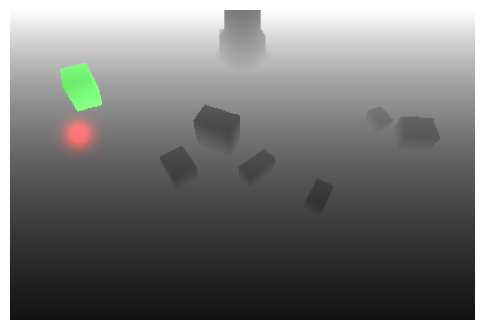

In [28]:
with h5py.File("dataset-final.h5", "r") as f:
    dp = f[list(f.keys())[1]]
    visualize_sample(dp["depth"][()], dp["mask"][()], dp["goal"][()])